In [271]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from stompy import utils
from stompy.plot import plot_utils
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

%matplotlib notebook


In [264]:
# Generate particle trajectories all at once:
class State:
    N=1000 # count of particles
    L=0.01 # our characteristic step length
    dt=1.0
    
    max_frames=10
    last_step=None
    times=[]
    fluxes=[]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        self.reset()
    def reset(self):
        xy=np.random.random( (self.N,2))
        particles=np.c_[xy,100*xy[:,0]] # x,y,temperature
        self.frames=[particles]
        self.fluxes=[0.0]
        self.times=[0.0]
        
    def step_forward(self,L=L):
        particles=self.frames[-1].copy()
        delta_xy=L*(np.random.random((self.N,2))-0.5)
        xy_new=particles[:,:2]+delta_xy
        outside=xy_new-xy_new.clip(0,1)
        xy_new-=2*outside
        particles[:,:2]=xy_new
        self.frames.append(particles)
        del self.frames[:-self.max_frames] # only keep recent frames
        self.times.append(self.times[-1]+self.dt)
        self.fluxes.append(self.calc_flux(self.frames[-2],self.frames[-1]))
    def calc_flux(self,part_old,part_new):
        "net flux positive rightward"
        Mlefts=[ part[part[:,0]<0.5,2].sum()
                 for part in [part_old,part_new]]
        return Mlefts[0]-Mlefts[1]

    def update(self,step,L=0.01):
        if step!=self.last_step:
            if step==0:
                self.reset()
            else:
                print("Stepping forward")
                self.step_forward(L=L)
            self.last_step=step


<IPython.core.display.Javascript object>


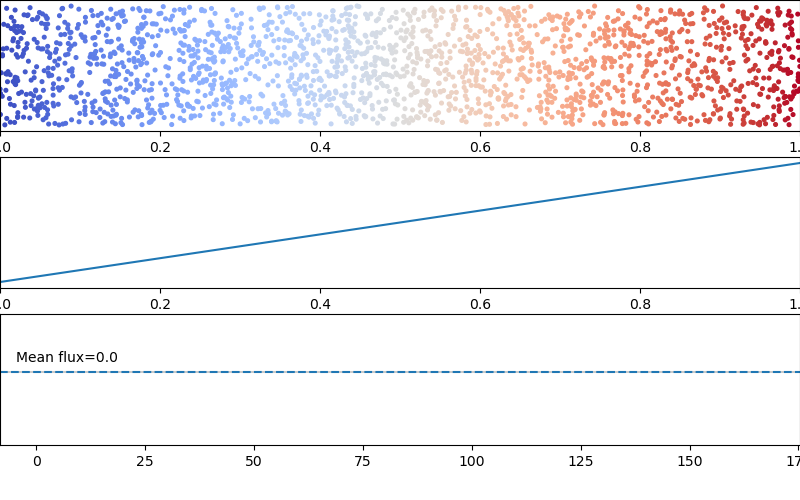

interactive(children=(Play(value=0, description='step', interval=50, max=10000), FloatSlider(value=0.01, descr…

''

In [279]:
state=State(N=2000)

fig=plt.figure(figsize=(8,5))
gs=GridSpec(3,1)
ax=fig.add_subplot(gs[0,:])
ax_h=fig.add_subplot(gs[1,:],sharex=ax)
ax_t=fig.add_subplot(gs[2,:])

fig.subplots_adjust(left=0,right=1,top=1.)

def plot_update(step,L):
    state.update(step,L)
    ax.cla()
    ax_h.cla()
    particles=state.frames[-1]
    scat=ax.scatter(particles[:,0],particles[:,1],7,
                    particles[:,2],cmap='coolwarm') ;

    order=np.argsort(particles[:,0])
    x_ord=particles[order,0]
    t_ord=particles[order,2]
    ax_h.plot(x_ord,t_ord)
    ax.axis(xmin=0,xmax=1)
    ax_t.lines=[]
    ax_t.plot(state.times,state.fluxes)
    lzero=ax_t.axhline(0,color='k',lw=0.3)
    flux_mean=np.mean(state.fluxes)
    lmean=ax_t.axhline(flux_mean,color='tab:blue',ls='--')
    ax_t.texts=[]
    plot_utils.annotate_line(lmean,f'Mean flux={flux_mean:.1f}',0.02,ha='left')
    fig.canvas.draw()

interact(plot_update,
         step=widgets.Play(value=0,
                           min=0, max=10000,
                           step=1, interval=50),
         L=widgets.FloatSlider(value=0.01,min=0,max=0.2,
             step=0.005,
             description='L:',
             orientation='horizontal',
             readout=True,
             readout_format='.3f'))
;